<figure>
   <IMG SRC="https://mamba-python.nl/images/logo_basis.png" WIDTH=125 ALIGN="right">
</figure>
# Congress twitter analysis

developed by Onno Ebbens



this notebook is created for the Mamba python course as an example for big data analysis.

table of content:
1. [import files](#1)
2. [read twitter data](#2)
3. [read user and party data](#3)
4. [combine datasets](#4)
5. [analyze twitter data per party](#5)
6. [plot results](#6)

## 1. import files<a class="anchor" id="1"></a>


In [1]:
import pandas as pd
import textblob as tb
import matplotlib.pyplot as plt
import datetime as dt
import pickle

In [2]:
#settings
%matplotlib inline
plt.style.use('seaborn')


## 2. read twitter data <a class="anchor" id="2"></a>

In [3]:
start_datum = dt.datetime(2018,2,1)
eind_datum = dt.datetime(2018,8,1)
date_range = pd.date_range(start_datum, eind_datum)

In [4]:
twitter_data = pd.DataFrame()
for datum in date_range:
    #print(datum)
    twitter_data_day = pd.read_json('https://raw.githubusercontent.com/alexlitel/congresstweets/master/data/%s.json'%datum.strftime('%Y-%m-%d'))
    twitter_data_day.index= pd.to_datetime(twitter_data_day.time)
    twitter_data = pd.concat([twitter_data, twitter_data_day])

## 3. read user and party data<a class="anchor" id="3"></a>

In [7]:
user_twitter = pd.read_json('https://raw.githubusercontent.com/alexlitel/congresstweets-automator/master/data/historical-users-filtered.json')

In [8]:
user_twitter['user_id'] = user_twitter.accounts.apply(lambda x: int(x[0]['id']))
user_twitter['screen_name'] = user_twitter.accounts.apply(lambda x: x[0]['screen_name'])

## 4. combine datasets<a class="anchor" id="4"></a>
link twitter users and political party

In [12]:
twitter_data['party'] = twitter_data.user_id.apply(lambda x: user_twitter[user_twitter.user_id==x]['party'].as_matrix()[0] if x in user_twitter.user_id.as_matrix() else 'U')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


## 5. analyze twitter data per party<a class="anchor" id="5"></a>
analyze the sentiment of the tweets

In [9]:
twitter_data['polarity'] = twitter_data.text.apply(lambda x: tb.Sentence(x).sentiment.polarity)

In [13]:
print('resultaat republikeinen')
print('aantal tweets geanalyseerd: %i'%twitter_data[twitter_data.party=='R'].shape[0])
print('gemiddelde polariteit:      %.2f'%twitter_data[twitter_data.party=='R'].polarity.mean())

resultaat republikeinen
aantal tweets geanalyseerd: 92282
gemiddelde polariteit:      0.20


In [14]:
print('resultaat democraten')
print('aantal tweets geanalyseerd: %i'%twitter_data[twitter_data.party=='D'].shape[0])
print('gemiddelde polariteit:      %.2f'%twitter_data[twitter_data.party=='D'].polarity.mean())

resultaat democraten
aantal tweets geanalyseerd: 151440
gemiddelde polariteit:      0.13


In [7]:
# load pickle to ommit previous time consuming steps

# with open(r'data\processed_twitter_data.pickle', 'wb') as pfile:
#     pickle.dump(twitter_data_rel, pfile)

with open(r'data\processed_twitter_data.pickle', 'rb') as pfile:
    twitter_data_rel = pickle.load(pfile)

In [8]:
twitter_data_d_daily_average = twitter_data_rel[twitter_data_rel.party=='D'].resample('D').mean()
twitter_data_r_daily_average = twitter_data_rel[twitter_data_rel.party=='R'].resample('D').mean()

## 6 plot results<a class="anchor" id="6"></a>

In [9]:
def add_annotation(ax, day, twitter_data_daily_average, 
                   connectionstyle, text, x_afstand=-20, y_afstand=0.3, facecolor='green', linewidth=None,
                   edgecolor=None):
    
    pol_day_party = twitter_data_daily_average[day:day]['polarity'].values[0]
    ax.annotate(text, 
                xy=(day, pol_day_party), 
                xytext=(day+dt.timedelta(x_afstand), pol_day_party+y_afstand), 
                fontsize=12,
                arrowprops=dict(arrowstyle="fancy", 
                                facecolor=facecolor, 
                                edgecolor=edgecolor ,
                                lw=linewidth,
                                connectionstyle=connectionstyle))
    return ax

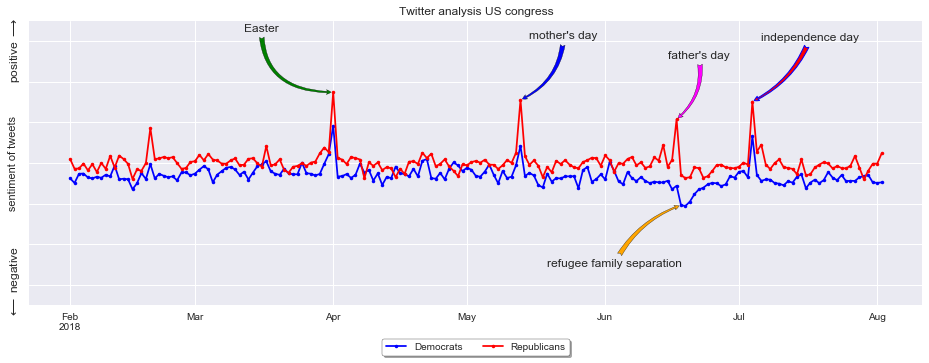

In [10]:
# plot
desired_width = 1920
desired_height = 1280
fig = plt.figure(figsize=(16,16/2.75))
ax = plt.subplot()
twitter_data_d_daily_average.polarity.plot(ax=ax, linestyle=None, marker='.', color='blue', label='Democrats')
twitter_data_r_daily_average.polarity.plot(ax=ax, linestyle=None, marker='.', color='red', label='Republicans')

# add arrows to the peaks
ax = add_annotation(ax, dt.datetime(2018,4,1), twitter_data_r_daily_average, "angle3,angleA=90,angleB=0",
                    'Easter')

ax = add_annotation(ax, dt.datetime(2018,5,13), twitter_data_r_daily_average, "arc3,rad=-0.3",
                    "mother's day", x_afstand=2, facecolor='blue')

ax = add_annotation(ax, dt.datetime(2018,6,17), twitter_data_r_daily_average, "arc3,rad=-0.3",
                    "father's day", x_afstand=-2, facecolor='magenta')

ax = add_annotation(ax, dt.datetime(2018,6,18), twitter_data_d_daily_average, "arc3,rad=-0.2",
                    "refugee family separation", x_afstand=-30, y_afstand=-0.3, facecolor='orange')

ax = add_annotation(ax, dt.datetime(2018,7,4), twitter_data_r_daily_average, "arc3,rad=-0.2",
                    "independence day", x_afstand=2 , facecolor='red', edgecolor='blue', linewidth=1)

ax.set_ylim(-0.5,0.9)
ax.set_xlabel('')
ax.set_ylabel('sentiment of tweets')
ax.set_yticklabels([])

xmin, xmax = ax.get_xlim()
ymin, ymax = ax.get_ylim()


ax.text(xmin-5, ymax-0.04, r'positive $\longrightarrow$', rotation=90, fontsize=12)
ax.text(xmin-5, ymin+0.24, r'$\longleftarrow$ negative', rotation=90, fontsize=12)




box = ax.get_position()
ax.set_position([box.x0, box.y0 + box.height * 0.1,
                 box.width, box.height * 0.9])


# Put a legend below current axis
leg = ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1),
                frameon=True, facecolor='white', edgecolor='black', shadow=True, ncol=5)

ax.set_title('Twitter analysis US congress')

fig.savefig(r'figures\twitter_analysis.png', dpi=500)